In [1]:
# set up matplotlib
%matplotlib widget
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams.update({"font.size": 14})

In [2]:
import numpy as np
import xarray as xr
from scipy.special import j0
from scipy.interpolate import RectBivariateSpline
from xbout import open_boutdataset

In [3]:
case = "1" # Case 1 is for anomalous density diffusion only.
filepath = "mms" + str(case) + "_2/BOUT.dmp.*.nc"
#filepath = "test" + str(case) + "/BOUT.dmp.0.nc"

ds = open_boutdataset(datapath=filepath, chunks={"t": 4})
dsn = xr.open_dataset("circle2_lowestres.fci.nc")

# Use squeeze() to get rid of the y-dimension, which has length 1 usually unless turbulent.
ds = ds.squeeze(drop=True)
dsn = dsn.squeeze(drop=True)

for key,val in ds.items():
    print(key)

Read in:
<xbout.BoutDataset>
Contains:
<xarray.Dataset> Size: 46MB
Dimensions:             (x: 68, y: 1, z: 68, t: 201)
Coordinates:
    dx                  (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 68), meta=np.ndarray>
    dy                  (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 68), meta=np.ndarray>
    dz                  (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 68), meta=np.ndarray>
  * t                   (t) float64 2kB 0.0 5e+05 1e+06 ... 9.95e+07 1e+08
  * x                   (x) int64 544B 0 1 2 3 4 5 6 7 ... 61 62 63 64 65 66 67
  * y                   (y) float64 8B 0.1963
  * z                   (z) float64 544B 0.007353 0.02206 ... 0.9779 0.9926
Data variables: (12/52)
    Bxy                 (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 68), meta=np.ndarray>
    G1                  (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 68), meta=np.ndarray>
    G2                  (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 

/home/tirkas1/miniconda3/lib/python3.13/site-packages/xbout/load.py:341: UserWarning: No geometry type found, no physical coordinates will be added
  warn("No geometry type found, no physical coordinates will be added")


In [4]:
dx = ds["dx"].isel(z=0).values

# Get rid of existing "x" coordinate, which is just the index values.
#ds = ds.drop("x")

# Create a new coordinate, which is length in units of rho_s
ds = ds.assign_coords(x=np.arange(ds.sizes["x"])*dx)

#Store just initial values as well.
ds_initial = ds.isel(t=0)

In [5]:
dens = ds["Nh+"][:,2:-2,:]
dens_true = dens.copy()

mask = dsn["in_mask"][2:-2,:]
ghost_id = dsn["ghost_id"].values
gst_pts = dsn["ghost_pts"].values
bdy_pts = dsn["bndry_pts"].values
img_pts = dsn["image_pts"].values
normals = dsn["normals"].values
is_plasma = dsn["is_plasma"].values
Rarr = dsn["R"].values[2:-2,:]
Zarr = dsn["Z"].values

timestep_for_errs_early = 10
timestep_for_errs_late = 100
spl_e = RectBivariateSpline(Rarr[:,0], Zarr[0,:], dens.values[timestep_for_errs_early,:,:], kx=1, ky=1)
spl_l = RectBivariateSpline(Rarr[:,0], Zarr[0,:], dens.values[timestep_for_errs_late,:,:], kx=1, ky=1)

In [6]:
alpha0 = 2.404825557693792
xc, zc = 1.5, 0.0

x_unit = 0.00022846974366979959 #rho_s0
w_unit = 95788333.030660808     #Omega_ci
t_unit = 1/w_unit

nx = 64*int(case)
nz = nx + 4
dx = np.float64(1.0) / np.float64(nx)
dz = np.float64(1.0) / np.float64(nz)

# Centers in x; faces/nodes in z if that's your convention
x = (np.arange(nx, dtype=np.float64) + 0.5) * dx     # centered x
z = (np.arange(nz, dtype=np.float64)) * dz           # unshifted z

xhalf  = np.float64(x[len(x)//2])
zhalf  = np.float64(z[len(z)//2])

xx, zz = np.meshgrid(x,z,indexing='ij',copy=False)
a      = np.float64(0.333333333333333)
D      = np.float64(0.2) #/(x_unit*x_unit*w_unit)
t64 = np.asarray(ds["t_array"].values, dtype=np.float64) # 1D time
t_norm = t64*t_unit
#spatial = ((xx - xhalf)**2 + (zz-zhalf)**2)
spatial = j0(alpha0*np.hypot(xx - 0.5, zz - 0.4962121212121212)/a)
#temp = 4.0*D*t_norm #t64/t64[-1]
a_norm = a/x_unit
temp = np.exp(-D * (alpha0 / a)**2 * (t_norm))

#dens_true[:,:,:] = np.asarray(spatial)[np.newaxis,:,:] + np.asarray(temp)[:,np.newaxis,np.newaxis]
dens_true[:,:,:] = np.asarray(spatial)[np.newaxis,:,:]*np.asarray(temp)[:,np.newaxis,np.newaxis]

bdy_pts_xz_e = spl_e.ev(bdy_pts[:,0], bdy_pts[:,1])
bdy_pts_xz_l = spl_l.ev(bdy_pts[:,0], bdy_pts[:,1])
print("Linf bdy err if dirichlet: " + str(np.max(np.abs(bdy_pts_xz_e))))
print("L2 bdy err (early) if dirichlet?: "  + str(np.mean(np.abs(bdy_pts_xz_e))))
print("L2 bdy err (late) if dirichlet?: "  + str(np.mean(np.abs(bdy_pts_xz_l))))

#dndR = spl.ev(bdy_pts[:,0], bdy_pts[:,1], dx=1, dy=0) # ∂n/∂R at boundary points
#dndZ = spl.ev(bdy_pts[:,0], bdy_pts[:,1], dx=0, dy=1) # ∂n/∂Z at boundary points
#dn_dn = dndR * normals[:,0] + dndZ * normals[:,1]     # normal derivative
dP = np.einsum('ij,ij->i', (bdy_pts - img_pts), -normals)
dG = np.einsum('ij,ij->i', (gst_pts - bdy_pts), -normals)
dn_dn_e = (spl_e.ev(img_pts[:,0], img_pts[:,1]) - spl_e.ev(gst_pts[:,0], gst_pts[:,1])) / (dP + dG)
dn_dn_l = (spl_l.ev(img_pts[:,0], img_pts[:,1]) - spl_l.ev(gst_pts[:,0], gst_pts[:,1])) / (dP + dG)

Linf = np.max(np.abs(dn_dn_e))
L2   = np.sqrt(np.mean(dn_dn_e**2))
L2   = np.sqrt(np.mean(dn_dn_l**2))
print("Linf bdy err if neumann: " + str(np.max(np.abs(dn_dn_e))))
print("L2 bdy err (early) if neumann: " + str(np.sqrt(np.mean(dn_dn_e**2))))
print("L2 bdy err (late) if neumann: " + str(np.sqrt(np.mean(dn_dn_l**2))))

Linf bdy err if dirichlet: 0.0009194606504362757
L2 bdy err (early) if dirichlet?: 0.00028841585671580017
L2 bdy err (late) if dirichlet?: 0.0001674213480847335
Linf bdy err if neumann: 1.2669427510484288
L2 bdy err (early) if neumann: 1.185852991070294
L2 bdy err (late) if neumann: 0.6874976769214902


In [7]:
img_pts_xz = spl_e.ev(img_pts[:,0], img_pts[:,1])

i = 0
for idx in range(nx+4):
    for idz in range(nz):
        gid = int(ghost_id[idx,idz])
        if gid >= 0:
            print(gid)
            if (not (is_plasma[gid,0] and is_plasma[gid,1] and is_plasma[gid,2] and is_plasma[gid,3])):
               print("Contains multiple ghost cell corners.")
            print(img_pts[gid])
            print(img_pts_xz[gid])

0
Contains multiple ghost cell corners.
[ 1.58423363 -0.28274185]
0.056092262087615405
1
[ 1.56335146 -0.24734359]
0.042825127659593454
2
[ 1.54558665 -0.21030669]
0.03158952402858078
3
Contains multiple ghost cell corners.
[ 1.53090909 -0.17048374]
0.02281788666541412
4
Contains multiple ghost cell corners.
[ 1.51971194 -0.12947139]
0.01626139455709864
5
Contains multiple ghost cell corners.
[ 1.51214157 -0.08688644]
0.011837147806776006
6
Contains multiple ghost cell corners.
[ 1.50831799 -0.04382069]
0.009601904107296302
7
Contains multiple ghost cell corners.
[ 1.50831799e+00 -2.96959961e-04]
0.009628949706266127
8
Contains multiple ghost cell corners.
[1.51214157 0.0427688 ]
0.011936723210106158
9
Contains multiple ghost cell corners.
[1.51971194 0.08535374]
0.01648755779819729
10
Contains multiple ghost cell corners.
[1.53090909 0.12636609]
0.023253332831195853
11
[1.54558665 0.16618904]
0.03235049961241687
12
[1.56335146 0.20322594]
0.04406868454891034
13
Contains multiple ghost

Dirichlet Linf int err: 0.3505039583979288
Dirichlet L2 int err (early): 0.18716240523788125
Dirichlet L2 int err (late): 0.2814951014373818
Neumann Linf int err: 0.19490956902857928
Neumann L2 int err (early): 0.10412555150431801
Neumann L2 int err (late): 0.15652618660766934
0


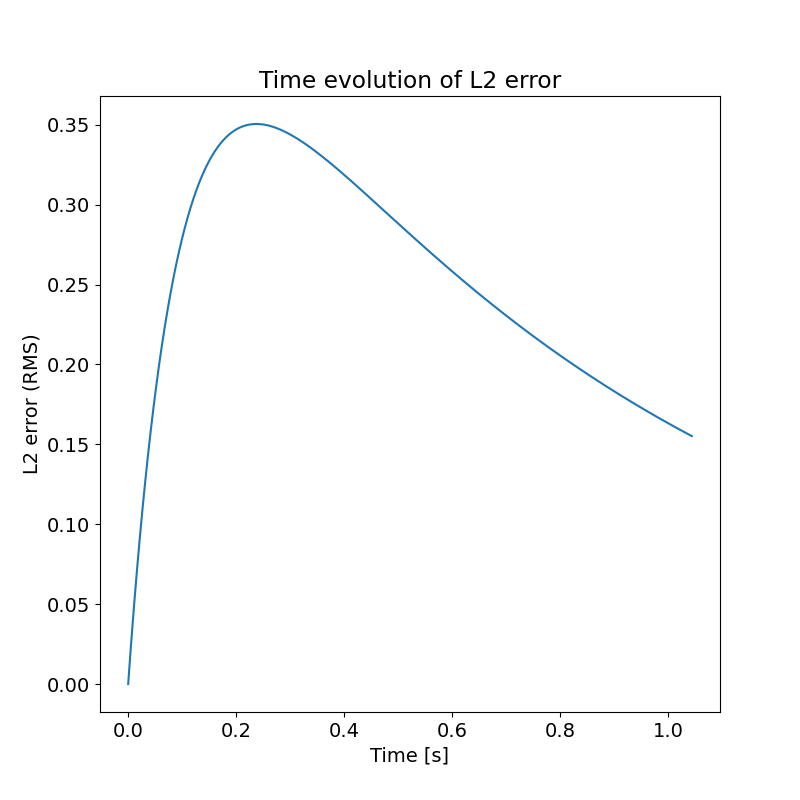

In [8]:
dens0 = dens.where(mask) - np.nanmean(dens.where(mask), axis=(1,2), keepdims=True)
true0 = dens_true.where(mask) - np.nanmean(dens_true.where(mask), axis=(1,2), keepdims=True)
dens_diff0 = dens0 - true0
dens_diff = dens.where(mask) - dens_true.where(mask)

l2_err_t = np.sqrt(np.nanmean(dens_diff**2, axis=(1, 2)))
l2_err_n_t = np.sqrt(np.nanmean(dens_diff0**2, axis=(1, 2)))

print("Dirichlet Linf int err: " + str(np.max(l2_err_t)))
print("Dirichlet L2 int err (early): "   + str(l2_err_t[timestep_for_errs_early]))
print("Dirichlet L2 int err (late): "   + str(l2_err_t[timestep_for_errs_late]))

print("Neumann Linf int err: " + str(np.max(l2_err_n_t)))
print("Neumann L2 int err (early): "   + str(l2_err_n_t[timestep_for_errs_early]))
print("Neumann L2 int err (late): "   + str(l2_err_n_t[timestep_for_errs_late]))
#l2_unnorm = np.sqrt(np.nansum(dens_diff[100,:,:]**2)*dx*dz)
#l2_rel = np.sqrt(np.nansum(dens_diff[100,:,:]**2)*dx*dz) / np.sqrt(np.nansum(dens_true[100,:,:]**2)*dx*dz)
#print("L2 (RMS): "    + str(l2_err))
#print("L2 (unnorm): " + str(l2_unnorm))
#print("L2 (rel): "    + str(l2_rel))

true = dens_true.values[1:10, len(x)//2, len(z)//2] - dens_true.values[0, len(x)//2, len(z)//2]
sim = dens.values[1:10, len(x)//2, len(z)//2] - dens.values[0, len(x)//2, len(z)//2]
#print(*np.abs(sim-true), sep="\n")

init_dens_diff = dens_diff[0,:,:]
mask2 = init_dens_diff.notnull() & (init_dens_diff >= 1e-10)
nerrs = int(mask2.sum().compute())

ii, jj = np.where(mask2)

if nerrs > 0:
    print(init_dens_diff.values[ii[0],jj[0]])
    print(dens.values[0,ii[0],jj[0]])
    print(dens_true.values[0,ii[0],jj[0]])

print(nerrs)

plt.plot(t_norm, l2_err_t)
plt.xlabel("Time [s]")
plt.ylabel("L2 error (RMS)")
plt.title("Time evolution of L2 error")
plt.show()

Nh+ data passed has 3 dimensions - will use animatplot.blocks.Pcolormesh()


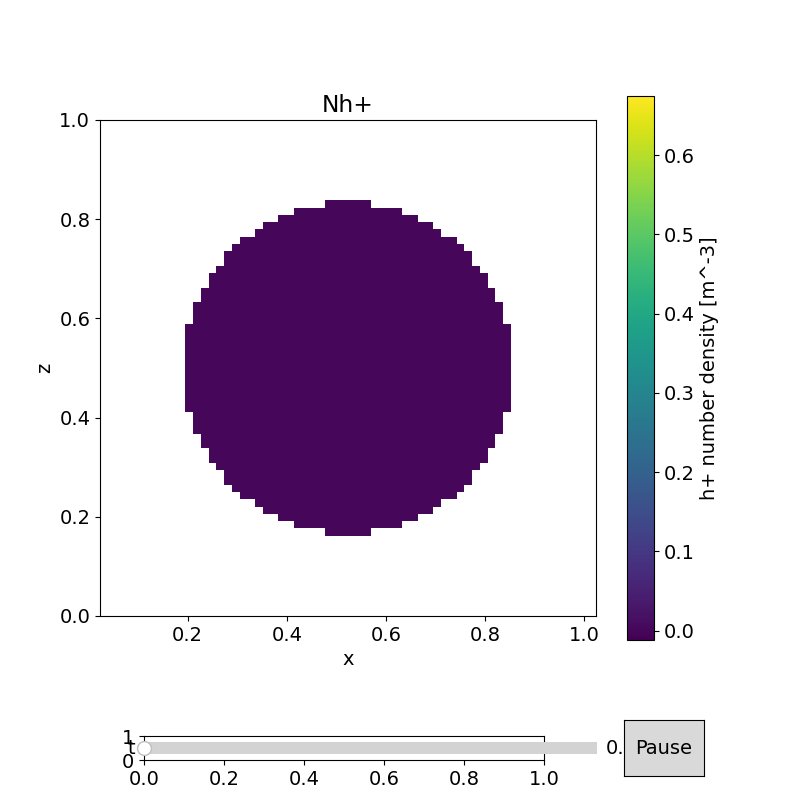

In [9]:
dens_diff.bout.animate2D(aspect='equal')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# dens: shape (nt, nx, nz)
# time: shape (nt,)
# dx, dz: scalar cell sizes (uniform grid)
# If nonuniform, use cell area weights instead of dx*dz.

area = dx * dz
# Compute L2 amplitude (norm of dens component)
amp = np.sqrt(np.nansum(dens**2, axis=(1, 2))*dx*dz)

# Take the natural log of amplitude
logA = np.log(amp)

# Choose a time window where the decay is clean (exclude t=0 if noisy)
t_fit = t_norm[5:]       # skip a few early points if needed
logA_fit = logA[5:]

# Linear fit: log(A) = a + b * t
coeffs = np.polyfit(t_fit, logA_fit, 1)
slope, intercept = coeffs[0], coeffs[1]

print(f"Measured slope = {slope:.6e}  (expected -D*alpha1^2)")

# Example for first root of J1
from scipy.special import jn_zeros
alpha1 = jn_zeros(0, 1)[0]  # ~3.8317 for J1's first root

expected_slope = -D * alpha1**2/a**2
print(f"Expected slope = {expected_slope:.6e}")
print(f"Ratio (measured/expected) = {slope / expected_slope:.3f}")

plt.figure(figsize=(6,4))
plt.plot(t_fit, logA_fit, 'o-', label='log(L2 amplitude)')
plt.plot(t_fit, intercept + slope*t_fit, 'r--', label=f'Fit slope = {slope:.3e}')
plt.plot(t_fit, np.log(amp[0]) + expected_slope*t_fit, 'k:', 
         label=f'Expected slope = {expected_slope:.3e}')
plt.xlabel('Time')
plt.ylabel('log(L2 amplitude)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
res_true = (D/(x_unit*x_unit*w_unit))*(alpha0**2/(a/x_unit)**2)*dens_true.where(mask)[0,:,:]
res_sim = ds["SNh+"][0,2:-2,:].where(mask)

res = res_sim + res_true

res_L2 = np.sqrt(np.nansum((res**2)) * dx*dz)
print("||res||_L2 =", float(res_L2)) #, "   relative =", float(rel_res))

In [ ]:
import numpy as np

# Inputs:
# uh, uex: arrays (time, nx, nz) or (nx, nz)
# mask: boolean (nx, nz) == True inside domain
# dx, dz: scalars; area per cell
area = dx*dz
h = min(dx, dz)

# --- simple binary erosion by 1 cell (4-neighborhood) ---
def erode1(m):
    return (m &
            np.roll(m,  1, 0) & np.roll(m, -1, 0) &
            np.roll(m,  1, 1) & np.roll(m, -1, 1))

def erode(m, k):
    out = m.copy()
    for _ in range(k):
        out = erode1(out)
    return out

# choose physical thickness delta = c*h0; set c=2 or 3
c = 2.0
k = max(1, int(np.ceil(c * h / h)))  # simplifies to int(c); keep form for clarity
mask_bool = mask > 0.5
mask_int = erode(mask_bool, k)            # interior region
mask_bnd = mask_bool & ~mask_int          # boundary band (k cells thick)

# error field at time index it
def l2_on(m, e):
    return np.sqrt(np.sum((e**2) * m) * area)

def l2_split(uh, uex, it):
    e = (uh[it] - uex[it])
    L2_full = l2_on(mask_bool, e)
    L2_int  = l2_on(mask_int, e)
    L2_bnd  = l2_on(mask_bnd, e)
    return L2_full, L2_int, L2_bnd

# example:
L2_full, L2_int, L2_bnd = l2_split(dens0.values, true0.values, it=10)
print(L2_full, L2_int, L2_bnd, L2_bnd/L2_full)


In [ ]:
print(dens.values[0,len(x)//2, len(z)//2])
print(dens.values[1,len(x)//2, len(z)//2])
print(dens_true.values[1,len(x)//2, len(z)//2])
print((dens - dens_true).values[1,len(x)//2,len(z)//2])

In [ ]:
print((2.404825557693792/3.8317059702075125)**2*0.2)